# [ Chapter 9 - Personalized Search ]
# Personalized Search

**NOTE**: This notebook depends upon the the Retrotech dataset. If you have any issues, please rerun the [Setting up the Retrotech Dataset](../ch04/1.setting-up-the-retrotech-dataset.ipynb) notebook or execute the next cell uncommented.

In [1]:
import sys
sys.path.append('../..')
import os
import random
import pickle
from collections import defaultdict
from datetime import datetime
from operator import itemgetter

import matplotlib.pyplot as plt
import numpy
import seaborn as sns
import sklearn.cluster as cluster
from aips import get_engine, display_product_search
from aips.spark import create_view_from_collection
from aips.spark.dataframe import from_sql
from pyspark.conf import SparkConf
from pyspark.ml.feature import IndexToString, StringIndexer
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode

engine = get_engine()

In [2]:
#Recommended for making ALS run faster, if you have enough memory / cores allocated to docker
conf = SparkConf()
conf.set("spark.driver.memory", "8g")
conf.set("spark.executor.memory", "8g")
conf.set("spark.dynamicAllocation.enabled", "true")
conf.set("spark.dynamicAllocation.executorMemoryOverhead", "8g")
spark = SparkSession.builder.appName("AIPS-ch9").config(conf=conf).getOrCreate()

In [3]:
#%run chapters/ch04/1.setting-up-the-retrotech-dataset.ipynb

In [4]:
### Load product data
products_collection = engine.get_collection("products")
create_view_from_collection(products_collection, "products", spark)

# Collaborative Filtering with Implicit Preferences

In [5]:
def aggregate_signals(signals_collection, signals_agg_collection_name, query):
    aggregated_collection = engine.create_collection(signals_agg_collection_name)
    print("Aggregating Signals to Create Signals Boosts...")
    create_view_from_collection(signals_collection, "signals", spark)
    aggregated_collection.write(from_sql(query, spark))
    print("Signals Aggregation Completed!")
    return aggregated_collection

## Listing 9.1

In [6]:
click_weight = 1
add_to_cart_weight = 0 ##increase to consider add-to-cart signals
purchase_weight = 0 ##increase to consider purchase signals

signals_collection = engine.get_collection("signals")

mixed_signal_types_aggregation = f"""
SELECT user, product,
  (click_boost + add_to_cart_boost + purchase_boost) AS rating
FROM (
  SELECT user, product, 
    SUM(click) AS click_boost,
    SUM(add_to_cart) AS add_to_cart_boost,
    SUM(purchase) AS purchase_boost
  FROM (  
    SELECT s.user, s.target AS product, 
      IF(s.type = 'click', {click_weight}, 0) AS click, 
      IF(s.type = 'add-to-cart', {add_to_cart_weight}, 0) AS add_to_cart,
      IF(s.type = 'purchase', {purchase_weight}, 0) AS purchase
    FROM signals s 
    WHERE (s.type != 'query')) AS raw_signals
  GROUP BY user, product) AS per_type_boosts"""

signals_agg_collection = \
  aggregate_signals(signals_collection, "user_product_implicit_preferences",
                    mixed_signal_types_aggregation)

Wiping "user_product_implicit_preferences" collection
Creating "user_product_implicit_preferences" collection
Status: Success
Aggregating Signals to Create Signals Boosts...
Successfully written 647441 documents
Signals Aggregation Completed!


## Listing 9.2

In [7]:
create_view_from_collection(signals_agg_collection, "user_product_implicit_preferences", spark)

##50K = all products
#This will take long time. Recommend setting to 1,000 if trying to just run through code
#without considering all products

top_product_count_for_recs = 50000 #1000 for older computers 
user_preference_query = f"""
SELECT user, product, rating
FROM user_product_implicit_preferences
WHERE product IN (
  SELECT product FROM (
    SELECT product, COUNT(user) user_count
    FROM user_product_implicit_preferences
    GROUP BY product
    ORDER BY user_count DESC
    LIMIT {top_product_count_for_recs}
  ) AS top_products)   
ORDER BY rating DESC"""

user_prefs = spark.sql(user_preference_query)

#test_collection = engine.create_collection("tcol")
#test_collection.write(from_sql(pref_query, spark))
#create_view_from_collection(test_collection, "temp_imp_preferences")
#user_prefs = spark.sql("SELECT user, product, rating from temp_imp_preferences order by rating DESC")

## Listing 9.3 

In [8]:
#Sometimes fails on first execution
#Fits a model to the input dataset with optional parameters.
def order_preferences(prefs):
    return prefs.orderBy(col("userIndex").asc(),
                         col("rating").desc(),
                         col("product").asc())

def strings_to_indexes(ratings, user_indexer,
                       product_indexer):
    return product_indexer.transform(user_indexer.transform(ratings))

def indexes_to_strings(ratings, user_indexer,
                       product_indexer):
    user_converter = IndexToString(inputCol="userIndex",
                                       outputCol="user",
                             labels=user_indexer.labels)
    product_converter = IndexToString(inputCol="productIndex",
                                          outputCol="product",
                                labels=product_indexer.labels)
    converted = user_converter.transform(
        product_converter.transform(ratings))
    return order_preferences(converted)

user_indexer = StringIndexer(inputCol="user", 
       outputCol="userIndex").fit(user_prefs)
product_indexer = StringIndexer(inputCol="product",
                          outputCol="productIndex").fit(user_prefs)

indexed_prefs = strings_to_indexes(user_prefs, user_indexer, product_indexer)
indexed_prefs.show(10)

+-------+------------+------+---------+------------+
|   user|     product|rating|userIndex|productIndex|
+-------+------------+------+---------+------------+
|u415401|024543750949|     2| 282571.0|        15.0|
|u531032|851342000865|     2|  37414.0|        29.0|
|u218785|885909457588|     2| 136002.0|         1.0|
| u54848|008888346845|     2| 381733.0|      2264.0|
| u19812|883929161881|     2| 120581.0|        43.0|
|u251380|022265003190|     2| 160325.0|       446.0|
| u78399|036725235182|     2|  19421.0|       638.0|
|u392565|883929152070|     2|   2111.0|     17587.0|
|u140605|885909528851|     2|   1444.0|       537.0|
|u212119|793276300904|     2|  14576.0|       591.0|
+-------+------------+------+---------+------------+
only showing top 10 rows



## Listing 9.4

In [9]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
random.seed(0)

als = ALS(maxIter=3, rank=10, regParam=0.15, implicitPrefs=True,
          userCol="userIndex", itemCol="productIndex", ratingCol="rating",
          coldStartStrategy="drop", seed=0)

(training_prefs, test_prefs) = user_prefs.randomSplit([0.8, 0.2], 0)
training_data = strings_to_indexes(training_prefs, user_indexer, product_indexer)
test_data = strings_to_indexes(test_prefs, user_indexer, product_indexer)

print("Beginning model training")
model = als.fit(training_data)

print("Beginning predictions")
predictions = model.transform(test_data)

print("Beginning evaluation")
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse}")

Beginning model training
Beginning predictions
Beginning evaluation
Root-mean-square error = 1.001211713780996


## Listing 9.5

In [10]:
# Generate top 10 product recommendations for each user
indexed_user_recs = model.recommendForAllUsers(10) \
                         .orderBy(col("userIndex").asc())
indexed_user_recs.show(5, truncate=64)

+---------+----------------------------------------------------------------+
|userIndex|                                                 recommendations|
+---------+----------------------------------------------------------------+
|        0|[{18, 0.0052840165}, {2, 0.005261404}, {15, 0.0047429726}, {1...|
|        1|[{21, 0.0042542047}, {3, 0.004202003}, {14, 0.0037469172}, {5...|
|        2|[{6, 0.0462252}, {5, 0.04412692}, {11, 0.03482225}, {15, 0.03...|
|        3|[{9, 0.036470007}, {2, 0.032314733}, {32, 0.024925873}, {71, ...|
|        4|[{9, 0.009652614}, {3, 0.007859741}, {10, 0.0067667062}, {38,...|
+---------+----------------------------------------------------------------+
only showing top 5 rows



## Listing 9.6

In [11]:
column_exploder = explode("recommendations").alias("productIndex_rating")
user_item_recs = indexed_user_recs.select("userIndex", column_exploder) \
                      .select("userIndex", col("productIndex_rating.*"))
user_item_recs = indexes_to_strings(user_item_recs, user_indexer,
                                    product_indexer)
user_item_recs = user_item_recs.select("user", "product",
                                       col("rating").alias("boost"))

# Listing 9.7

In [12]:
print("Start Time: " + datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

recs_collection = engine.create_collection("user_item_recommendations")
recs_collection.write(user_item_recs)

print("End Time: " + datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Start Time: 2024-08-18 17:37:26
Wiping "user_item_recommendations" collection
Creating "user_item_recommendations" collection
Status: Success
Successfully written 4450620 documents
End Time: 2024-08-18 17:42:03


# Search with Recommendations Boosts
Whereas signals boosting boosts the most popular documents for a particular query (ch8), you can also boost the most personalized items for a particular user. In order to serve up the pre-generated collaborative recommendations we just generated, we can just need to run a search and boost the recommended items for each user.

## Listing 9.8

In [13]:
from pyspark.sql.functions import lit, date_format
def scrub(name): 
    return name.replace("&#xAE;","®").replace("&#x2122;", "™")

def print_interaction_history(user_id, signals):
    products_collection = engine.get_collection("products")    
    interacted_products = [s["target"] for s in signals]
    request = {"filters": [("upc", interacted_products)]}
    products = products_collection.search(**request)["docs"]
    
    product_info = {p["upc"]: p["name"] for p in products}
    for s in signals:
        s |= {"name": scrub(product_info.get(s["target"], s["target"]))}

    print(f"Previous Product Interactions for User: {user_id}")
    dataframe = spark.createDataFrame(signals)
    dataframe = dataframe.select(date_format('signal_time', 'MM/dd HH:MM').alias("signal_time"),
                                 "type", "target", "name")
    dataframe.show(10, truncate=37)

In [14]:
def signals_request(user_id):
    return {"query": "*",
            "return_fields": ["signal_time", "type", "target"],
            "order_by": [("signal_time", "desc")],
            "filters": [("user", user_id)]}    

user_id = "u478462" #example user
signals_collection = engine.get_collection("signals")

request = signals_request(user_id)
previous_signals = signals_collection.search(**request)["docs"]
print_interaction_history(user_id, previous_signals)

Previous Product Interactions for User: u478462
+-----------+-----------+------------+-------------------------------------+
|signal_time|       type|      target|                                 name|
+-----------+-----------+------------+-------------------------------------+
|05/25 07:05|      click|885909464043|Apple® - MacBook® Air - Intel® Cor...|
|05/25 06:05|      query|     macbook|                              macbook|
|05/20 07:05|   purchase|885909457588|Apple® - iPad® 2 with Wi-Fi - 16GB...|
|05/20 07:05|add-to-cart|885909457588|Apple® - iPad® 2 with Wi-Fi - 16GB...|
|05/20 07:05|      click|885909457588|Apple® - iPad® 2 with Wi-Fi - 16GB...|
|05/20 06:05|      query|       apple|                                apple|
+-----------+-----------+------------+-------------------------------------+



## Listing 9.9

In [15]:
# %load -s product_search_request engine/search_requests
def product_search_request(query, param_overrides={}):
    request = {"query": query,
               "query_fields": ["name", "manufacturer", "long_description"],
               "return_fields": ["upc", "name", "manufacturer",
                                 "short_description", "score"],
               "limit": 5,
               "order_by": [("score", "desc"), ("upc", "asc")]}
    return request | param_overrides

In [16]:
def get_query_time_boosts(user, boosts_collection):
    request = {"query": "*",
               "return_fields": ["product", "boost"],
               "filters": [("user", user)] if user else [],
               "limit": 10,
               "order_by": [("boost", "desc")],
               "log": True}
    
    response = boosts_collection.search(**request)
    signals_boosts = response["docs"]
    return " ".join(f'"{b["product"]}"^{b["boost"] * 100}' for b in signals_boosts)

def search_for_products(query, signals_boosts):
    request = product_search_request(query if query else "*")
    if signals_boosts:
        request["query_boosts"] = ("upc", signals_boosts)
    return products_collection.search(**request)

In [17]:
user = "u478462"
boosts = get_query_time_boosts(user, recs_collection)
response = search_for_products("", boosts)

print(f"Boost Query:\n{boosts}")
display_product_search("", response["docs"])

{
  "query": "*",
  "limit": 10,
  "params": {
    "log": true
  },
  "fields": [
    "product",
    "boost"
  ],
  "filter": [
    "user:u478462"
  ],
  "sort": "boost desc"
}
{
  "responseHeader": {
    "zkConnected": true,
    "status": 0,
    "QTime": 1
  },
  "response": {
    "numFound": 10,
    "start": 0,
    "numFoundExact": true,
    "docs": [
      {
        "product": "885909457588",
        "boost": 0.78626615
      },
      {
        "product": "711719842309",
        "boost": 0.1699873
      },
      {
        "product": "022265004289",
        "boost": 0.121856965
      },
      {
        "product": "821793013776",
        "boost": 0.08472641
      },
      {
        "product": "885370325348",
        "boost": 0.058183152
      },
      {
        "product": "612572171585",
        "boost": 0.05752262
      },
      {
        "product": "885909436705",
        "boost": 0.056722745
      },
      {
        "product": "851342000865",
        "boost": 0.0534204
      },
   

## Listing 9.10

In [18]:
query = "tablet"
response = search_for_products(query, None)
print(f"Non-personalized Query")
display_product_search(query, response["docs"])

Non-personalized Query


In [19]:
response = search_for_products(query, boosts)
print(f"Personalized Query")
display_product_search(query, response["docs"])

Personalized Query


# Vector-based Personalization

In [20]:
spark.sql("""SELECT COUNT(upc), COUNT(DISTINCT upc), COUNT(name), COUNT(DISTINCT name), COUNT(DISTINCT short_description) FROM products g""").show(2)

+----------+-------------------+-----------+--------------------+---------------------------------+
|count(upc)|count(DISTINCT upc)|count(name)|count(DISTINCT name)|count(DISTINCT short_description)|
+----------+-------------------+-----------+--------------------+---------------------------------+
|     48194|              46156|      48194|               46124|                            19024|
+----------+-------------------+-----------+--------------------+---------------------------------+



## Listing 9.11

In [21]:
### Create the product data set for embeddings 
query = "SELECT DISTINCT name, string(upc), short_description FROM products"
spark.sql(query).createOrReplaceTempView("products_samples")
product_names = dataframe.select("name").rdd.flatMap(lambda x: x).collect()
product_ids = dataframe.select("upc").rdd.flatMap(lambda x: x).collect()

In [22]:
len(product_ids), len(product_names)

(48164, 48164)

In [23]:
from sentence_transformers import SentenceTransformer

## picked this model "all-mpnet-base-v2" based on benchmark on this link https://medium.com/@nils_reimers/openai-gpt-3-text-embeddings-really-a-new-state-of-the-art-in-dense-text-embeddings-6571fe3ec9d9
transformer = SentenceTransformer("all-mpnet-base-v2")

## Listing 9.12

In [24]:
def get_embeddings(texts, cache_name, ignore_cache=False):
    cache_file_name = f"data/embeddings/{cache_name}.pickle"
    if ignore_cache or not os.path.isfile(cache_file_name):
        embeddings = transformer.encode(texts)
        os.makedirs(os.path.dirname(cache_file_name), exist_ok=True)
        with open(cache_file_name, "wb") as fd:
            pickle.dump(embeddings, fd)
    else:
        with open(cache_file_name, "rb") as fd:
            embeddings = pickle.load(fd)
    return embeddings

In [25]:
#product_embeddings=get_embeddings(p_texts,load_from_cache=True)
#product_embeddings=get_embeddings(product_names,load_from_cache=True)
product_embeddings = get_embeddings(product_names, "all_product_names_5")

In [26]:
### Product Ids-embedding, Product ID-names dictionaries 
product_ids_emb = dict(zip(product_ids, product_embeddings))
product_ids_names = dict(zip(product_ids, product_names))
#len(product_texts), len(product_embeddings), len(product_names) ,len(product_ids),len(product_ids_names.values())
len(product_embeddings), len(product_names), len(product_ids), len(product_ids_names.values())

(48164, 48164, 48164, 46156)

## Listing 9.13

In [27]:
random.seed(0)

## Get the clusters 
def get_clusters(data, algorithm, args):
    return algorithm(**args, random_state=0).fit(data)

def assign_clusters(labels, product_names):
    clusters = defaultdict(lambda:[], {})
    for i in range(len(labels)):
        clusters[labels[i]].append(product_names[i])
    return clusters

args = {"n_clusters": 100, "n_init": 10}
algo = get_clusters(product_embeddings, cluster.KMeans, args)
labels = algo.predict(product_embeddings)
clusters = assign_clusters(labels, product_names)

## Listing 9.14

155

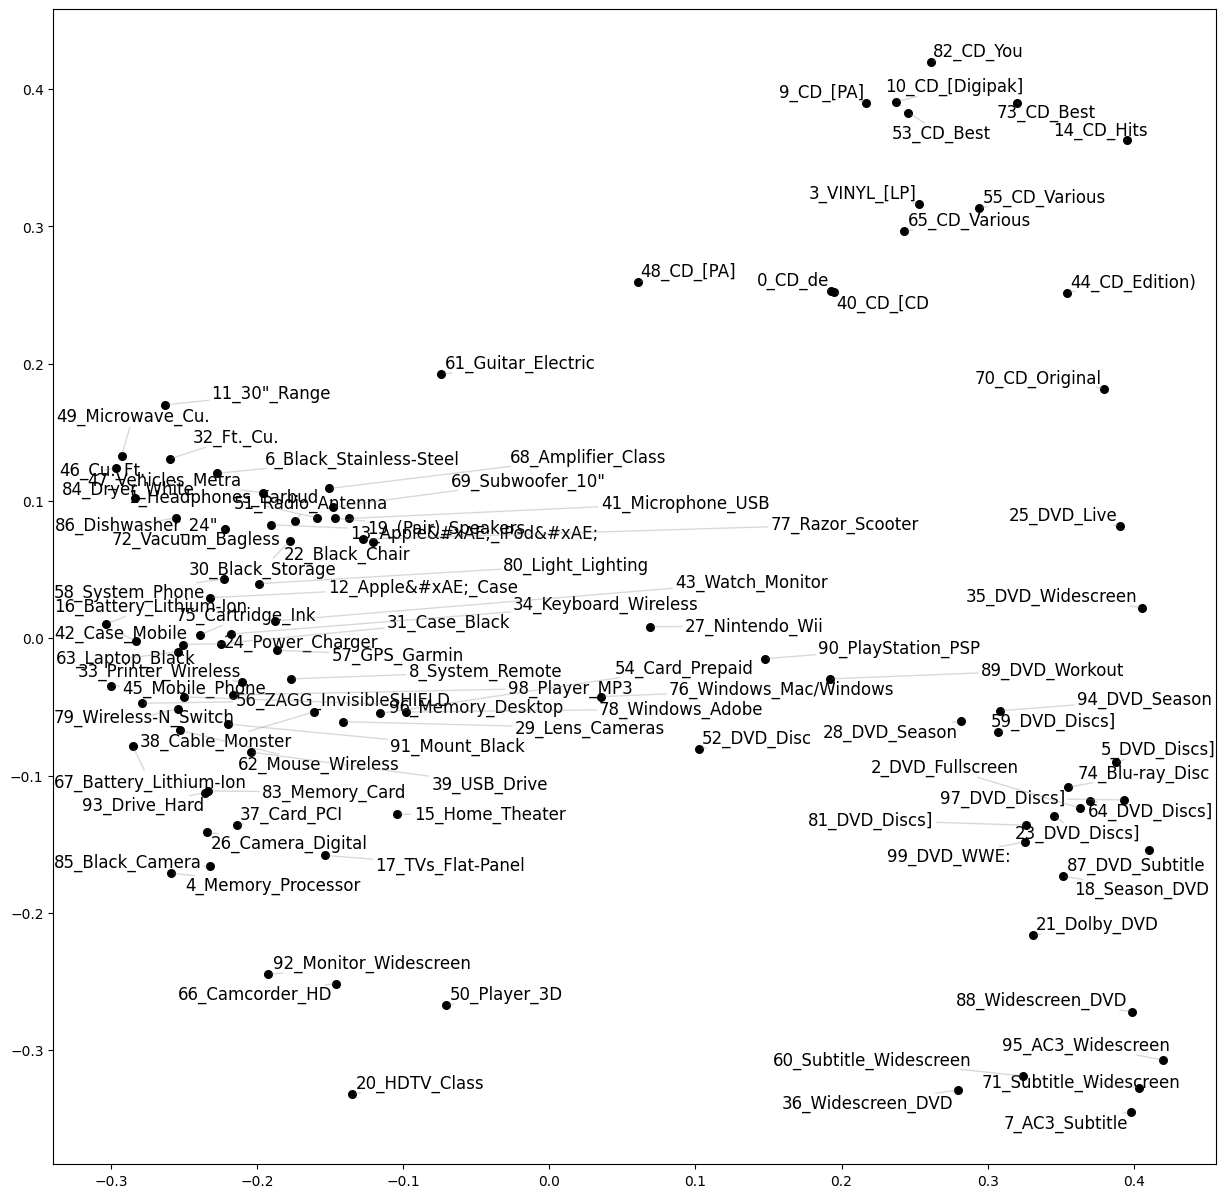

In [28]:
import collections, itertools, numpy as np, matplotlib.pyplot as plt
from adjustText import adjust_text
from sklearn.decomposition import PCA

stopwords = ["in", "for", "with", "of", "the", "to", "and"]

def top_words(clusters, top_n):
    # Loop through the clusters and split each string on space
    tokenized = [cluster.split() for cluster in clusters]
    # Flatten the list of lists
    flattened = list(itertools.chain.from_iterable(tokenized))
    filtered = [word for word in flattened
                if len(word) > 1 and word.lower() not in stopwords]
    
    # Return the most common words
    return [word for word, _ 
            in collections.Counter(filtered).most_common(top_n)]

#Transform the data for 2-D visualization
plt.figure(figsize=(15, 15))
pca = PCA(100, svd_solver="full")
centers = algo.cluster_centers_
plot_data = pca.fit_transform(centers)

points = []
for i, cluster_name in enumerate(plot_data):
    plt.scatter(plot_data[i, 0], plot_data[i, 1],
                s=30, color="k") 
    label = f"{i}_{'_'.join(top_words(clusters[i], 2))}"
    points.append(plt.text(plot_data[i, 0],
                           plot_data[i, 1],
                           label, size=12))
adjust_text(points, arrowprops=dict(arrowstyle="-",
                          color="gray", alpha=0.3))

In [29]:
clusters[1]  #useful for spot checking clusters to ensure items inside are homogenous

['Midland - Headset Speaker and Microphone for Open-Face Helmets',
 'AKG - Perception Wireless Vocal Set - Black',
 'Sony - Earbud Headphones - Pink',
 'AKG - Over-the-Ear Mini Headphones - Silver',
 'Yurbud - Ear Bud Enhancers',
 'Sony - PIIQ Over-the-Ear Headphones - Yellow',
 "Skullcandy - Ink'd Ear Bud Stereo Headphones - Black/Red",
 'Jabra - STONE2 Bluetooth Headset',
 'Panasonic - Hands-Free Headset - Black',
 'BlueAnt - Bluetooth Headset',
 'Bose&#xAE; - OE2i Audio Headphones - White',
 'Koss - PRO4AAT Stereo Headphones',
 'Bose&#xAE; - MIE2i mobile headset - Black/Silver',
 'Turtle Beach - Ear Force X12 Gaming Headset for Xbox 360',
 'Plantronics - Savi 700 Wireless Headset System',
 'Beats By Dr. Dre - Heartbeats Earbud Headphones - Black',
 'Klipsch - Image S4i Earbud Headphones with Microphone and 3-Button Remote',
 'Plantronics - Marque M155 Bluetooth Headset - Black/Silver',
 'Plantronics - Savi Go Convertible Earset',
 'Klipsch - Image S5i Rugged Earbud Headphones',
 'Me

In [30]:
#sample top keywords in each cluster (same as figure above, but more data)
for cluster_key in range(0,99):
    print(f"{{ cluster: {cluster_key}, top_words: {top_words(clusters[cluster_key], 20)}}}")

{ cluster: 0, top_words: ['CD', 'de', 'DVD', 'La', 'El', 'Various', 'Exitos', 'De', 'Los', 'Vol.', 'Grandes', '[CD', 'DVD]', 'En', 'el', 'Amor', 'Vivo', '[ECD]', 'en', 'la']}
{ cluster: 1, top_words: ['Headphones', 'Earbud', 'Headset', 'Over-the-Ear', 'Black', 'Skullcandy', 'Sennheiser', 'Stereo', 'Ear', 'Sony', 'Bluetooth', 'Wireless', 'White', 'Microphone', 'Gaming', 'Bud', 'Beats', 'AKG', 'DJ', 'Blue']}
{ cluster: 2, top_words: ['DVD', 'Fullscreen', 'Discs]', 'Widescreen', 'Dubbed', 'Christmas', 'Blu-ray', '[2', 'Disc', 'Subtitle', 'Dolby', 'Little', 'Collection', 'Vol.', 'AC3', 'Movie', 'Disc)', '[3', 'Complete', 'Adventures']}
{ cluster: 3, top_words: ['VINYL', '[LP]', '[PA]', 'Vinyl', '12-Inch', 'Single', 'Disc]', '[12inch', 'CD', '(Ogv)', '[Single]', 'Edition)', '[EP]', '(Limited', 'Vol.', 'Various', 'Is', 'White', 'No', '[Digipak]']}
{ cluster: 4, top_words: ['Memory', 'Processor', 'Drive', 'Hard', 'Intel&#xAE;', 'Laptop', 'Display', '4GB', 'Core&#x2122;', 'HP', '15.6"', 'AMD',

In [31]:
import pandas 

### Create Pandas dataframes for product_clusters
product_ids_labels = dict(zip(product_ids, labels))
pddf_product_ids_labels = pandas.DataFrame.from_dict(product_ids_labels, orient="index", columns=["label"])
pddf_product_ids_labels["pid"] = pddf_product_ids_labels.index

## Listing 9.15 Comparing approaches for mapping queries to product clusters

In [32]:
import sentence_transformers, heapq

## get the top n clusters based on similairty with centers 
def get_top_labels_centers(query, centers, n=2):
    q_embedding = transformer.encode([query], convert_to_tensor=False)
    similarities = sentence_transformers.util.cos_sim(q_embedding, centers)
    sim = similarities.tolist()[0]
    return [sim.index(i) for i in heapq.nlargest(n, sim)]

### Get the cluster for the query based on prediction of the label
def get_query_cluster(query):
    q_embedding = transformer.encode([query], convert_to_tensor=False)
    return algo.predict(q_embedding)

def get_cluster_description(cluser_num):
    return "_".join(top_words(clusters[cluser_num], 5))

In [33]:
random.seed(0)

query = "microwave"
#option 1: Find nearest cluster (KMeans)
kmeans_predict = get_query_cluster(query)[0]
print("KMeans Predicted Cluster:")
print(f"    {kmeans_predict} ({get_cluster_description(kmeans_predict)})")

#option 2: Find most similar cluster (Cosine similarity)
closest_cosine_similarity = get_top_labels_centers(query, centers, 1)[0]
print(f"""\nCosine Predicted Cluster:\n    {closest_cosine_similarity}
      {get_cluster_description(closest_cosine_similarity)})""")

#option 3: N-nearest clusters (Cosine similarity)
knn_cosine_similarity = get_top_labels_centers(query, centers, 5)
print(f"\nKNN Cosine Predicted Clusters: {knn_cosine_similarity}")
for n in knn_cosine_similarity:
      print(f"    {n} ({get_cluster_description(n)})")

KMeans Predicted Cluster:
    49 (Microwave_Cu._Ft._Stainless-Steel_Oven)

Cosine Predicted Cluster:
    49
      Microwave_Cu._Ft._Stainless-Steel_Oven)

KNN Cosine Predicted Clusters: [49, 6, 11, 32, 84]
    49 (Microwave_Cu._Ft._Stainless-Steel_Oven)
    6 (Black_Stainless-Steel_Cuisinart_KitchenAid_Maker)
    11 (30"_Range_Stainless-Steel_Self-Cleaning_Freestanding)
    32 (Ft._Cu._Refrigerator_Water_Thru-the-Door)
    84 (Dryer_White_Cu._Ft._Electric)


In [34]:
sdf_id_labels = spark.createDataFrame(pddf_product_ids_labels).createOrReplaceTempView('products_clusters')

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/local/spark/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [35]:
# Load signal data to create user-product vectors
signals_collection = engine.get_collection("signals")
create_view_from_collection(signals_collection, "signals", spark)

In [36]:
#Create User-product data set for personalization
spark.sql("""SELECT DISTINCT user, target AS product_id, name AS product_name
FROM signals s JOIN products_samples p ON s.target = p.upc
WHERE s.type = 'click'""").createOrReplaceTempView("user_product")

query = """SELECT user, product_id, product_name, label FROM user_product a
JOIN products_clusters b ON a.product_id = b.pid"""

user_product_cluster_collection = engine.create_collection("user_product_cluster")
user_product_cluster_collection.write(from_sql(query, spark))

Wiping "user_product_cluster" collection
Creating "user_product_cluster" collection
Status: Success
Successfully written 431392 documents


In [37]:
## get the top n clusters based on similarity with centers 
def top_clusters_for_embedding(embedding, n=2):
    similarities = sentence_transformers.util.cos_sim(embedding, centers)
    sim = similarities.tolist()[0]
    return [sim.index(i) for i in heapq.nlargest(n, sim)]

## Listing 9.16

In [38]:
# importiong the modules
import pandas, numpy
numpy.set_printoptions(4)

#Take user's product interests and return dataframe containing embedding and guardrail cluster
def get_user_embeddings(products=[]):
    values = []
    for p in products:
        values.append([product_ids_emb[p], top_clusters_for_embedding(product_ids_emb[p], 1)[0]])
    return pandas.DataFrame(data=numpy.array(values), index=products,
                            columns=["embedding", "cluster"])

def get_personalization_vector(query=None,
                               user_items=[],
                               query_weight=1,
                               user_items_weights=[]):
    #by default, weight is split 1:1 (50% each) between the query embedding and the user_items_weight.
    #you can manually add weights for each user_item to influence how much each element counts.

    query_embedding = transformer.encode(query) if query else None
    
    if len(user_items) > 0 and len(user_items_weights) == 0:
        user_items_weights = numpy.full(shape=len(user_items),
                                        fill_value=1 / len(user_items))
            
    embeddings = []
    embedding_weights = []
    for weight in user_items_weights:
        embedding_weights.append(weight) 
    for embedding in user_items:
        embeddings.append(embedding)
    if query_embedding.any():
        embedding_weights.append(query_weight)
        embeddings.append(query_embedding)
    
    return numpy.average(embeddings, weights=numpy.array(embedding_weights),
                      axis=0).astype("double") if len(embeddings) else None

## Listing 9.17

In [39]:
def format_vector(vector):
    return "[" + (", ".join([str(round(n, 3)) for n in vector]))[0:70] + " ...]"

In [40]:
product_interests = [ "7610465823828",  #hello kitty water bottle
                      "36725569478"]   #stainless steel electric range

user_embeddings = get_user_embeddings(product_interests)
print(f"\nProducts Interactions for Personalization:\n {user_embeddings}")

query = "microwave"

unfiltered_personalization_vector = get_personalization_vector(query=query,
                        user_items=user_embeddings['embedding'].to_numpy())
print("\nPersonalization Vector (No Cluster Guardrails):")
print(format_vector(unfiltered_personalization_vector))

query_clusters = get_top_labels_centers(query, centers, n=5)
print("\nQuery Clusters ('microwave'):\n" + str(query_clusters))

clustered = user_embeddings.cluster.isin(query_clusters)
products_in_cluster = user_embeddings[clustered] #filter down to only items in the query clusters
print("\nProducts Filtered to Query Clusters:\n" + str(products_in_cluster))

filtered_personalization_vector = get_personalization_vector(query=query,
                             user_items=products_in_cluster['embedding'].to_numpy())
print("\nFiltered Personalization Vector (With Cluster Guardrails):")
print(format_vector(filtered_personalization_vector))


Products Interactions for Personalization:
                                                        embedding cluster
7610465823828  [0.06417941, 0.04178553, -0.0017139615, -0.020...      72
36725569478    [0.0055417763, -0.024302201, -0.024139373, -0....      11

Personalization Vector (No Cluster Guardrails):
[0.016, -0.006, -0.02, -0.032, -0.016, 0.008, -0.0, 0.017, 0.011, 0.007 ...]

Query Clusters ('microwave'):
[49, 6, 11, 32, 84]

Products Filtered to Query Clusters:
                                                     embedding cluster
36725569478  [0.0055417763, -0.024302201, -0.024139373, -0....      11

Filtered Personalization Vector (With Cluster Guardrails):
[0.002, -0.023, -0.026, -0.037, -0.025, 0.002, -0.009, 0.007, 0.033, -0 ...]


/tmp/ipykernel_7083/4263540528.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return pandas.DataFrame(data=numpy.array(values), index=products,


## Listing 9.18

In [41]:
from operator import itemgetter

def rerank_with_personalization(docs, personalization_vector):
    result_embeddings = numpy.array(
        [product_ids_emb[docs[x]['upc']]
         for x in range(len(docs))]).astype(float)
    similarities = sentence_transformers.util.cos_sim(personalization_vector,
                                                result_embeddings).tolist()[0]
    reranked = [similarities.index(i)
                for i in heapq.nlargest(len(similarities), similarities)]
    reranked, _ = zip(*sorted(enumerate(similarities),
                              key=itemgetter(1), reverse=True))
    return [docs[i] for i in reranked]

In [45]:
query = "microwave"
request = product_search_request(query, {"limit": 100})

response = products_collection.search(**request)
docs = response["docs"]
print("No Personalization:")
display_product_search(query, docs[0:4])

No Personalization:


In [46]:
print("Global Personalization (No Category Guardrails):")
reranked_seach_results_no_guardrails = \
    rerank_with_personalization(docs,
        unfiltered_personalization_vector) 
display_product_search(query, reranked_seach_results_no_guardrails[0:4])

Global Personalization (No Category Guardrails):


In [47]:
print("Contextual Personalization (with Category Guardrails):")
reranked_seach_results_with_guardrails = \
    rerank_with_personalization(docs,
        filtered_personalization_vector) 
display_product_search(query, reranked_seach_results_with_guardrails[0:4])

Contextual Personalization (with Category Guardrails):


Up next: Chapter 10 - [Learning to Rank for Generalizable Search Relevance](../ch10/1.setup-the-movie-db.ipynb)